# **前提**

In [ ]:
## mount drive 先把google drive挂载到colab左边的临时列表下，
## 然后会出现drive这个目录，里面包含了所有drive中的东西
from google.colab import drive
drive.mount('/content/drive') 

## 在左边找到要unzip的文件的绝对路径，然后复制到下面
!unzip '/content/drive/MyDrive/Colab Notebooks/5329/a2/data.zip' -d '/content/drive/MyDrive/Colab Notebooks/5329/a2/data'

In [ ]:
#### csv文本读取方法
import pandas as pd
import numpy as np
import re
import csv

#train = np.genfromtxt("train.csv",delimiter=',') # 用于load txt csv
#train = pd.read_csv('train.csv', sep=',',header=None) # 用于load 结构化数据，但是这里有的是3列，有的是4列
#train = np.load("train.csv",allow_pickle=True) # 用于load .npy
#train = np.loadtxt("train.csv", delimiter=',') # 只有csv文件中都是数字，.jpg这种格式不支持
#with open("train.csv") as f:
#    data = csv.reader(f, delimiter = ',',)


In [ ]:
from glob import glob 
import cv2
all_images = glob("data/*.jpg")
image0 = cv2.imread(all_images[0])
plt.imshow(image0[:,:,::-1])

# **0 Importing Packages**



In [1]:
import torch
from torch import tensor, nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, models, transforms
from sklearn import metrics

# **1 Load data**

**1.1 Data Loading**



In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. 验证身份并创建pydrive客户端.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
downloaded = drive.CreateFile({'id': '1MQoBbuJANnSaZ5qzFGH5iqXpocYNgmOT'})
downloaded.GetContentFile('train.csv')

downloaded = drive.CreateFile({'id': '1L8AjKScAYvHIqIloI57vny17REAILfT4'})
downloaded.GetContentFile('test.csv')

downloaded = drive.CreateFile({'id': '1xg_Su0hWF2Dmw05-4mXTXBcxWOhKuCx_'})
downloaded.GetContentFile('data.zip')

In [ ]:
!unzip data.zip -d data

In [5]:
import pandas as pd
import numpy as np
import re
import csv
train = pd.read_csv('train.csv', sep=',')
test = pd.read_csv('test.csv', sep=',')

In [6]:
def label_transform(l):
    y_ls = []
    for each_label in l:
        if each_label > 12:
            each_label -= 1
        each_label -= 1
        y_ls.append(each_label)
    return y_ls

In [7]:
import os
from PIL import Image

def load_data(root = '/content/data/data'):
    train_images, train_x, train_y, train_caption = [], [], [], []
    test_images, test_x, test_caption = [], [], []
    for i, name in enumerate(sorted(os.listdir(root))):
        img = Image.open(os.path.join(root, name))
        name_ls = int(name.split('.')[0])
        if name_ls < 30000:
            idx = train[train.ImageID == name].index[0]
            train_images.append(name)
            img = np.asarray(img)
            train_x.append(img)
            y = list(map(int, train.Labels.iloc[idx].split()))
            y_trans = label_transform(y)
            y = F.one_hot(torch.tensor(y_trans), 18)
            # 如果总共有三维: 
            # dim=0代表0维与0维之间折叠起来; 
            # dim=1代表1维(每一行)与1维之间折叠起来;
            # dim=2代表2维(每一列)与2维之间折叠起来
            # reference: https://towardsdatascience.com/understanding-dimensions-in-pytorch-6edf9972d3be
            y = y.sum(dim=0)
            train_y.append(np.array(y))
            train_caption.append(train.Caption.iloc[idx])
            
        else:
            idx = test[test.ImageID == name].index[0]
            test_images.append(name)
            img = np.asarray(img)
            test_x.append(img)
            test_caption.append(test.Caption.iloc[idx])

        #img = img.resize([s//reduce for s in img.size])
    # reference: https://blog.csdn.net/weixin_44109545/article/details/115240842
    
    return train_images, np.array(train_x), np.array(train_y), np.array(train_caption), test_images, np.array(test_x), np.array(test_caption)

In [8]:
# train = (30000,) 
# test = (10000,)
train_images, train_x, train_y, train_caption, test_images, test_x, test_caption = load_data()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


**1.2 Defining Dataloaders**

In [9]:
BATCH_SIZE = 128
NUM_WORKERS = 1

In [11]:
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DataProcess(Dataset):
    def __init__(self, data, labels=None, transform=None, test=False):
        self.data = data
        self.label = labels
        self.transform = transform
        self.test = test
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.test == True: 
            x = self.data[idx]
            x_copy = x.copy()
            if self.transform:
                x_copy = self.transform(x_copy)
            return x_copy

        x = self.data[idx]
        y = self.label[idx]
        x_copy = x.copy()
        if self.transform:
            x_copy = self.transform(x_copy)
        # reference: https://blog.csdn.net/dong_liuqi/article/details/109823874
       # y = np.pad(y, (0, 20-y.shape[0]), 'constant', constant_values=(0, -1))
        return (x_copy,y)



def get_loader():

    transform = transforms.Compose([
            transforms.ToTensor(),                        
            transforms.Resize((224,224)),
            
           # transforms.RandomCrop(32, padding = 4),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.224)),
           # transforms.RandomHorizontalFlip()  
    ])
   # mean = np.array([0.485, 0.456, 0.406])
   # std = np.array([0.229, 0.224, 0.224])
   #  (x/255-mean)/std

    train = DataProcess(train_x, train_y, transform)
    train_size = int(0.8*len(train)) # 24000
    val_size = int(0.2*len(train)) # 6000
    train_dataset, val_dataset = random_split(train, [train_size, val_size])

    test = DataProcess(test_x, transform = transform, test=True)

    train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True,
                          num_workers = NUM_WORKERS)
    
    val_loader = DataLoader(dataset = val_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True,
                          num_workers = NUM_WORKERS)
    
    test_loader = DataLoader(dataset = test,
                          batch_size = 1,
                          shuffle = False)
    
    return train_loader, val_loader, test_loader


In [13]:
train_loader, val_loader, test_loader = get_loader()

# **2 Model Definition**

In [10]:
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(in_features=512, out_features=18, bias=True)
resnet50.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [159]:
resnet50_2 = models.resnet50(pretrained=True)
resnet50_2.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=512, bias=True),
    nn.Linear(in_features=512, out_features=18, bias=True))
resnet50_2.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
resnet50_3 = models.resnet50(pretrained=True)
resnet50_3 = models.resnet50(pretrained=True)
resnet50_3.fc = nn.Linear(in_features=512, out_features=18, bias=True)

layers = [
          resnet50_3.conv1,
          resnet50_3.bn1,
          resnet50_3.relu,
          resnet50_3.maxpool,
          resnet50_3.layer1,
          resnet50_3.layer2,
          resnet50_3.avgpool,
          resnet50_3.fc
]
resnet50_new = nn.Sequential(*layers).to('cuda')

In [ ]:
resnet101 = models.resnet101(pretrained=True)
resnet101.fc = nn.Linear(in_features=2048, out_features=18, bias=True)
resnet101.to('cuda')

# **3 Training and Testing Procedures**

In [1]:
# multi-label: sigmoid + cross entropy
# reference: https://lipengwei.github.io/2018/08/03/CNN%E5%A4%9A%E6%A0%87%E7%AD%BE%E5%88%86%E7%B1%BB%E5%AE%9E%E6%88%98/
# reference: https://lipengwei.github.io/2018/07/31/%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E4%B9%8Bloss/
# f1-score:
# reference: https://gist.github.com/SuperShinyEyes/dcc68a08ff8b615442e3bc6a9b55a354
# reference: https://scikit-learn.org/stable/modules/model_evaluation.html#from-binary-to-multiclass-and-multilabel

def train(model, epochs, train_loader, optimizer, criterion):
    model.train()
    for ep_idx in range(epochs):
        ep_loss = 0.0
        ep_f1_score = 0.0
        for step, (x, y) in enumerate(train_loader):
            x = x.to('cuda')
            y = y.float().to('cuda')
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out,y)
            #_, preds = torch.max(out.to('cpu'), dim=1)
            #print(out.data.shape)
            #print(y.shape)
            f1_score = metrics.f1_score( y.data.cpu().numpy(), out.data.cpu().numpy()>THRESHOLD, average='samples')

            ep_loss += loss
            ep_f1_score += f1_score
            loss.backward()
            optimizer.step()
       # print("epoch %d/%d: loss = %.2f" %(ep_idx+1, epochs, ep_loss/(step+1)))
        print("epoch %d/%d:" % (ep_idx+1, epochs))
        print("train# loss = %.2f, f1 score = %.2f" %(ep_loss/(step+1), ep_f1_score/(step+1)))     
        val(model, val_loader,criterion)    

def val(model, val_loader, criterion):
    model.eval()
    with torch.no_grad():
        ep_loss = 0.0
        ep_f1_score = 0.0
        for step, (x, y) in enumerate(val_loader):
            x = x.to('cuda')
            y = y.float().to('cuda')
            out = model(x)
            loss = criterion(out,y)
            f1_score = metrics.f1_score( y.data.cpu().numpy(), out.data.cpu().numpy()>THRESHOLD, average='samples')
            ep_loss += loss
            ep_f1_score += f1_score 
        print("val# loss = %.2f, acc = %.2f" %(ep_loss/(step+1), ep_f1_score/(step+1)))

def test(model, test_loader):
    model.eval()
    output = []
    with torch.no_grad():
        for step, x in enumerate(test_loader):
            x = x.to('cuda')
            out = model(x)
            out = torch.sigmoid(out)
            output.append(out)
    return output

# **4 Runtime**

**model 1**

In [31]:
EPOCHS = 6
LEARNING_RATE = 0.0001
MOMENTUM = 0.9
#optimizer = torch.optim.SGD(resnet50.parameters(), LEARNING_RATE, MOMENTUM)
#optimizer = torch.optim.Adam(resnet50.parameters(), LEARNING_RATE)
optimizer_2 = torch.optim.Adam(resnet50_2.parameters(), LEARNING_RATE)
criterion = nn.MultiLabelSoftMarginLoss()
criterion_BCE = nn.BCEWithLogitsLoss()
# criterion = MultiLabelMarginLoss
THRESHOLD = 0.5

In [14]:
train(resnet50, EPOCHS, train_loader, optimizer, criterion)

epoch 1/10:
train# loss = 0.14, f1 score = 0.71
val# loss = 0.09, acc = 0.80
epoch 2/10:
train# loss = 0.09, f1 score = 0.80
val# loss = 0.10, acc = 0.78
epoch 3/10:
train# loss = 0.07, f1 score = 0.87
val# loss = 0.09, acc = 0.81
epoch 4/10:
train# loss = 0.06, f1 score = 0.89
val# loss = 0.10, acc = 0.82
epoch 5/10:
train# loss = 0.05, f1 score = 0.92
val# loss = 0.10, acc = 0.81
epoch 6/10:
train# loss = 0.04, f1 score = 0.93
val# loss = 0.11, acc = 0.83
epoch 7/10:
train# loss = 0.03, f1 score = 0.95
val# loss = 0.12, acc = 0.82
epoch 8/10:
train# loss = 0.03, f1 score = 0.96
val# loss = 0.12, acc = 0.83
epoch 9/10:
train# loss = 0.02, f1 score = 0.97
val# loss = 0.14, acc = 0.83
epoch 10/10:
train# loss = 0.02, f1 score = 0.97
val# loss = 0.13, acc = 0.84


In [47]:
torch.save(resnet50,"resnet50.pkl")

In [15]:
output = test(resnet50, test_loader)

**model 2**

In [28]:
train(resnet50_2, EPOCHS, train_loader, optimizer_2, criterion_BCE)

epoch 1/8:
train# loss = 0.10, f1 score = 0.76
val# loss = 0.09, acc = 0.80
epoch 2/8:
train# loss = 0.08, f1 score = 0.83
val# loss = 0.09, acc = 0.80
epoch 3/8:
train# loss = 0.06, f1 score = 0.87
val# loss = 0.09, acc = 0.81
epoch 4/8:
train# loss = 0.05, f1 score = 0.90
val# loss = 0.10, acc = 0.79
epoch 5/8:
train# loss = 0.04, f1 score = 0.92
val# loss = 0.10, acc = 0.83
epoch 6/8:
train# loss = 0.04, f1 score = 0.93
val# loss = 0.11, acc = 0.83
epoch 7/8:
train# loss = 0.03, f1 score = 0.95
val# loss = 0.13, acc = 0.82
epoch 8/8:
train# loss = 0.02, f1 score = 0.96
val# loss = 0.13, acc = 0.83


In [33]:
torch.save(resnet50_2,"resnet50_2.pkl")

In [61]:
output_2 = test(resnet50_2, test_loader)

# **Test Result**

In [93]:
Label = []
for img in output_2:
    l = []
    img = np.squeeze(img.data.cpu().numpy())
    for i in range(18):
        if img[i] > THRESHOLD:
            l.append(i)
    Label.append(l)

In [155]:
def label_transform_original(a):
    label = []
    for i in range(len(a)):
        l = []
        for j in a[i]:
            if j >= 11:
                j += 1
            j+=1
            l.append(str(j))
        label.append([test_images[i]," ".join(l)])
    return label

In [156]:
label = label_transform_original(Label)

In [158]:
import pandas as pd

head_name=['ImageID', 'Labels']
file_content = pd.DataFrame(columns=head_name,data=label)
file_content.to_csv('predict_result_2.csv', index=False)

In [ ]:
from matplotlib import image
import matplotlib.pyplot as plt

img = 0
for i in test_loader:
    img = i
    break

plt.imshow(img[0][1])

In [69]:
o[0][4].data.cpu().numpy()

array([9.9985015e-01, 1.3862969e-05, 9.9445795e-05, 1.3061014e-05,
       1.8415577e-06, 5.5402586e-05, 2.8225541e-05, 6.0484599e-05,
       9.6157886e-04, 1.0445542e-06, 2.4895284e-05, 3.0537183e-05,
       2.2205402e-05, 7.1643776e-06, 6.9849542e-03, 1.4869279e-04,
       9.1648028e-05, 5.5404751e-05], dtype=float32)

In [24]:
x = x.detach().cpu()
sorted_indices = np.argsort(x)
sorted_indices

tensor([ 7,  9, 10, 11,  3,  8,  5,  2, 12, 17, 16,  6,  4, 13,  0, 14,  1, 15])

In [ ]:
## example
import torch
import numpy as np

pred = np.array([[-0.4089, -1.2471, 0.5907],
                [-0.4897, -0.8267, -0.7349],
                [0.5241, -0.1246, -0.4751]])
label = np.array([[0, 1, 1],
                  [0, 0, 1],
                  [1, 0, 1]])

pred = torch.from_numpy(pred).float()
label = torch.from_numpy(label).float()

crition1 = torch.nn.BCEWithLogitsLoss()
loss1 = crition1(pred, label)
print(loss1)

crition2 = torch.nn.MultiLabelSoftMarginLoss()
loss2 = crition2(pred, label)
print(loss2)
f1_score = metrics.f1_score( label.data.to('cuda').numpy(), pred.data.to('cuda').numpy()>0, average='samples')
print(f1_score)

tensor(0.7193)
tensor(0.7193)
0.4444444444444444


**model 3**

In [ ]:
EPOCHS = 8
LEARNING_RATE = 0.001
optimizer = torch.optim.SGD(resnet101.parameters(), LEARNING_RATE)
criterion = nn.MultiLabelSoftMarginLoss()

In [ ]:
train(resnet101, EPOCHS, train_loader, optimizer, criterion)

RuntimeError: ignored

# **Reference**

1. 
```
https://thevatsalsaglani.medium.com/training-and-deploying-a-multi-label-image-classifier-using-pytorch-flask-reactjs-and-firebase-c39c96f9c427
https://zhuanlan.zhihu.com/p/67220643
---
2. 

```
https://blog.csdn.net/ganxiwu9686/article/details/103080695
```



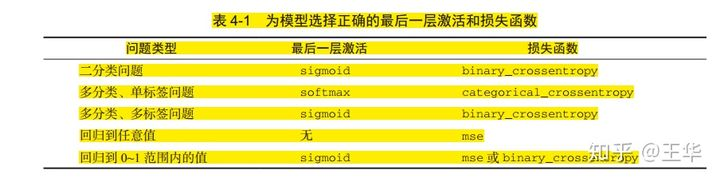
---

---
3. 
```
https://debuggercafe.com/multi-label-image-classification-with-pytorch-and-deep-learning/
```
